In [1]:

from transformers import pipeline
from rouge_score import rouge_scorer
import pandas as pd
import kagglehub
import os

c:\Users\abamr\Desktop\ELovoTasks\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
path = kagglehub.dataset_download("gowrishankarp/newspaper-text-summarization-cnn-dailymail")
print("Path to dataset:", path)
cnn_path = os.path.join(path, "cnn_dailymail")


Path to dataset: /kaggle/input/newspaper-text-summarization-cnn-dailymail


In [6]:
train_df = pd.read_csv(f"{cnn_path}/train.csv")
val_df = pd.read_csv(f"{cnn_path}/validation.csv")
test_df = pd.read_csv(f"{cnn_path}/test.csv")


print(train_df['article'].keys())  # 'article', 'highlights'

RangeIndex(start=0, stop=287113, step=1)


In [9]:
def preprocess_text(text, max_length=512):
    text = str(text).replace("\n", " ").strip()
    # Truncate to model-friendly length
    return " ".join(text.split()[:max_length])

# Apply preprocessing
train_df['article'] = train_df['article'].apply(preprocess_text)
train_df['highlights'] = train_df['highlights'].apply(preprocess_text)

val_df['article'] = val_df['article'].apply(preprocess_text)
val_df['highlights'] = val_df['highlights'].apply(preprocess_text)

In [21]:
from transformers import pipeline

# Load summarization pipeline

bart_summarizer = pipeline(
    "summarization",
    model="sshleifer/distilbart-cnn-12-6",
    device=-1
)

Device set to use cpu


In [24]:
n_samples = 10
texts =train_df['article'][:n_samples]

bart_summaries = []
for text in texts:
    summary = bart_summarizer(
        text,
        max_length=130,
        min_length=30,
        do_sample=False,
        truncation=True
    )[0]['summary_text']
    bart_summaries.append(summary)

In [25]:
# Use the 'summary' column from the dataset
references = train_df['highlights'][:n_samples]

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_results = []

for ref, pred in zip(references, bart_summaries):
    scores = scorer.score(ref, pred)
    rouge_results.append(scores)

df_rouge = pd.DataFrame(rouge_results)
df_rouge.head()


,rouge1,rouge2,rougeL
0,"(0.27419354838709675, 0.5, 0.35416666666666663)","(0.18032786885245902, 0.3333333333333333, 0.23...","(0.22580645161290322, 0.4117647058823529, 0.29..."
1,"(0.39622641509433965, 0.6, 0.4772727272727273)","(0.21153846153846154, 0.3235294117647059, 0.25...","(0.3018867924528302, 0.45714285714285713, 0.36..."
2,"(0.4878048780487805, 0.5714285714285714, 0.526...","(0.20987654320987653, 0.2463768115942029, 0.22...","(0.25609756097560976, 0.3, 0.2763157894736842)"
3,"(0.5909090909090909, 0.5098039215686274, 0.547...","(0.3953488372093023, 0.34, 0.3655913978494624)","(0.5454545454545454, 0.47058823529411764, 0.50..."
4,"(0.31746031746031744, 0.29850746268656714, 0.3...","(0.11290322580645161, 0.10606060606060606, 0.1...","(0.2222222222222222, 0.208955223880597, 0.2153..."


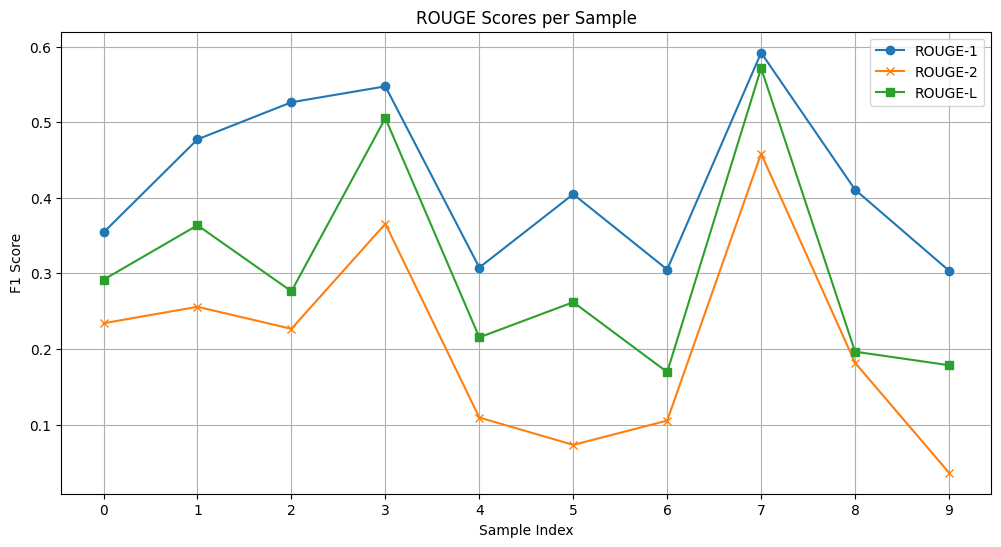

In [26]:
import matplotlib.pyplot as plt

# Extract average scores for each metric per sample
rouge1_scores = [r['rouge1'].fmeasure for r in rouge_results]
rouge2_scores = [r['rouge2'].fmeasure for r in rouge_results]
rougeL_scores = [r['rougeL'].fmeasure for r in rouge_results]

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(rouge1_scores, label='ROUGE-1', marker='o')
plt.plot(rouge2_scores, label='ROUGE-2', marker='x')
plt.plot(rougeL_scores, label='ROUGE-L', marker='s')

plt.xlabel('Sample Index')
plt.ylabel('F1 Score')
plt.title('ROUGE Scores per Sample')
plt.legend()
plt.grid(True)

# Force x-axis ticks to be integers
plt.xticks(range(len(rouge1_scores)))

plt.show()

